# Topic 19: Multiple Linear Regression

- onl01-dtsc-ft-022221
- 04/08/21

## Resources:

- **[OSEMN Data Science Workflow Notebook](https://github.com/jirvingphd/fsds-osemn-workflow)**
    - `student_OSEMN.ipynb`: also included in notes repo

## LEARNING OBJECTIVES

- Learn how to expand our last lesson to include multiple independent variables.
- Learn ways to deal with categorical variables.
- Learn about multicollinearity of features
- Learn about how to improve a baseline model based on results
- Learn how to run a multiple regression using statsmodels

<!-- ### TOPICS:

#### Part 1 
- Multiple Linear Regression
- Dealing with Categorical Variables
- Multicollinearity of Features
- Multiple Linear Regression in Statsmodels

#### Part 2
- Feature Scaling & Normalization
- Model Fit and Validation/Cross Validation -->

## Questions?



- 

# PREVIOUSLY ON... Topic 18

- We discussed how the mean is our worst model.

- We discussed the assumptions for a linear regression:
    - Linear relationship between predictor and target variable.
    - Predictor (x) and its error terms have a normal distribution
    - Homoskedasticity ( variance of residuals is constant)
    
- We learned how to run a single regession in statsmodels

In [1]:
# !pip install -U fsds
# from fsds.imports import *
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from scipy import stats

In [2]:
plt.style.use('seaborn-notebook')
# plt.rcParams['figure.figsize'] = [10,6]
pd.set_option('display.float_format', lambda x: f"{x:,}")
pd.set_option('display.max_columns',0)

In [3]:
## Importing our study group functions
%load_ext autoreload
%autoreload 2
import sys
    
py_folder = "../../py_files/" # CHANGE TO REFECT YOUR NOTEBOOKS LOCATION COMPARED TO THE PY_FILES FOLDER
sys.path.append(py_folder)
import functions_SG as sg

## Predicting Revenue with Budget - Baseline

In [4]:
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
### NEW MOVIE DATASET
## Thanks to Johnny Dryma for letting us use his data
movie_data_url = "https://raw.githubusercontent.com/Drymander/dsc-phase-1-project/master/data/2012-2019%20FULL.csv"
dfm = pd.read_csv(movie_data_url,index_col=0,parse_dates=['release_date'])

## List of cols that need processsing before use
cols_need_processing=['genres','production_companies',
                      'belongs_to_collection']

## Save only the columns of interest
df = dfm[['id','imdb_id','original_title','title','genres','mpaa_rating',
     'production_companies','release_date','runtime','budget','revenue',
     'vote_count','vote_average','popularity','adult','original_language']].copy()

del dfm

## Keep only movies with financial data
df=df[(df['budget']>0) & (df['revenue']>0)]

## Feature Engineering
# df['profit'] = df['revenue'] - df['budget']
# df['ROI'] = df['profit']/df['budget']

## Removing Extreme values for class purposes
# df=df[df['ROI']<1000]

## Drop nulls & reset index
df.dropna(inplace=True)
df.set_index('id',inplace=True)

display(df.head(),df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 24428 to 630331
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   imdb_id               1300 non-null   object        
 1   original_title        1300 non-null   object        
 2   title                 1300 non-null   object        
 3   genres                1300 non-null   object        
 4   mpaa_rating           1300 non-null   object        
 5   production_companies  1300 non-null   object        
 6   release_date          1300 non-null   datetime64[ns]
 7   runtime               1300 non-null   float64       
 8   budget                1300 non-null   int64         
 9   revenue               1300 non-null   int64         
 10  vote_count            1300 non-null   int64         
 11  vote_average          1300 non-null   float64       
 12  popularity            1300 non-null   float64       
 13  adult       

,imdb_id,original_title,title,genres,mpaa_rating,production_companies,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",PG-13,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",PG,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en
57214,tt1636826,Project X,Project X,"[{'id': 35, 'name': 'Comedy'}]",R,"[{'id': 1885, 'logo_path': '/xlvoOZr4s1Pygosrw...",2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 21, 'logo_path': '/aOWKh4gkNrfFZ3Ep7n0...",2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en


None

In [6]:
## Fixing genres
df['genre_list'] = df['genres'].map(lambda x: eval(x))
df['genre_list'] = df['genre_list'].map(lambda x: [g['name'] for g in x])
df

,imdb_id,original_title,title,genres,mpaa_rating,production_companies,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language,genre_list
id,,,,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",PG-13,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,"[Science Fiction, Action, Adventure]"
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en,"[Adventure, Fantasy, Drama, Romance]"
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",PG,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en,"[Family, Animation, Comedy, Adventure]"
57214,tt1636826,Project X,Project X,"[{'id': 35, 'name': 'Comedy'}]",R,"[{'id': 1885, 'logo_path': '/xlvoOZr4s1Pygosrw...",2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en,[Comedy]
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 21, 'logo_path': '/aOWKh4gkNrfFZ3Ep7n0...",2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en,"[Adventure, Fantasy, Action]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",PG-13,"[{'id': 264, 'logo_path': '/fA90qwUKgPhMONqtwY...",2019-12-11,174.0,9000000,4612788,370,7.2,15.434000000000001,False,en,"[Drama, War, History]"
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",PG,"[{'id': 7493, 'logo_path': '/452FO4LcI6lA6bfgl...",2019-11-07,119.0,15600000,11620337,211,6.7,15.075999999999999,False,en,"[Drama, Comedy]"
616584,tt10521814,K-12,K-12,"[{'id': 10402, 'name': 'Music'}, {'id': 27, 'n...",R,"[{'id': 65827, 'logo_path': None, 'name': 'Atl...",2019-09-05,92.0,50000,359377,171,7.6,14.822000000000001,False,en,"[Music, Horror, Fantasy]"


In [7]:
genre_df = df.explode('genre_list')
genre_df

,imdb_id,original_title,title,genres,mpaa_rating,production_companies,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language,genre_list
id,,,,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",PG-13,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,Science Fiction
24428,tt0848228,The Avengers,The Avengers,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",PG-13,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,Action
24428,tt0848228,The Avengers,The Avengers,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",PG-13,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,Adventure
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en,Adventure
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",PG-13,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619265,tt10555920,The Cabin House,The Cabin House,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",R,"[{'id': 74190, 'logo_path': None, 'name': 'G.P...",2019-10-31,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,en,Horror
619265,tt10555920,The Cabin House,The Cabin House,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",R,"[{'id': 74190, 'logo_path': None, 'name': 'G.P...",2019-10-31,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,en,Thriller
630331,tt10931434,Cin-Si Bozuk,Cin-Si Bozuk,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NR,[],2019-09-06,95.0,46,5,0,0.0,0.622,False,en,Comedy


### Model 1

#### Checking Assumption of Linearity

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:xlabel='budget', ylabel='revenue'>)

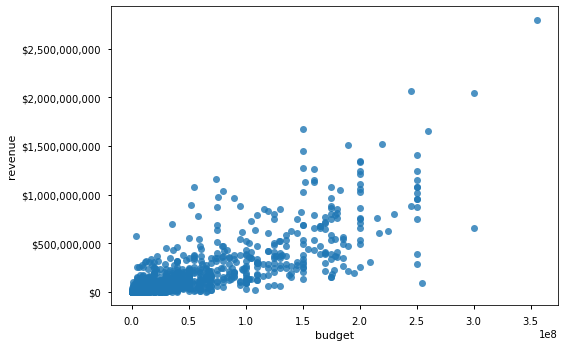

In [8]:
## Scatter Plots for Linearity Check
priceFmt = mpl.ticker.StrMethodFormatter("${x:,.0f}")
roiFmt = mpl.ticker.StrMethodFormatter("{x:,.2f}%")

def plot_data(X='budget',y='revenue',data=df,fit_reg=False):
    ax = sns.regplot(x=X,y=y,data=data,fit_reg=fit_reg)
    ax.yaxis.set_major_formatter(priceFmt)
    fig=ax.get_figure()
    return fig,ax

plot_data()

#### Statsmodels OLS - Formula Version

In [9]:
f = "revenue~budget"
model1 = smf.ols(f,df).fit()
display(model1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2127.
Date:                Wed, 07 Apr 2021   Prob (F-statistic):          9.19e-276
Time:                        19:15:58   Log-Likelihood:                -26440.
No. Observations:                1300   AIC:                         5.288e+04
Df Residuals:                    1298   BIC:                         5.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.858e+07   5.93e+06     -3.136      0.002   -3.02e+07   -6.96e+06
budget         3.7903      0.082     46.120      0.000       3.629       3.951
==============================================================================
Omnibus:                      708.628   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12328.555
Skew:                           2.134   Prob(JB):                         0.00
Kurtosis:                      17.470   Cond. No.                     9.35e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Checking Assumptions

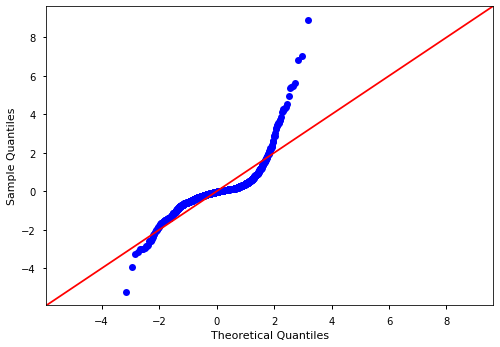

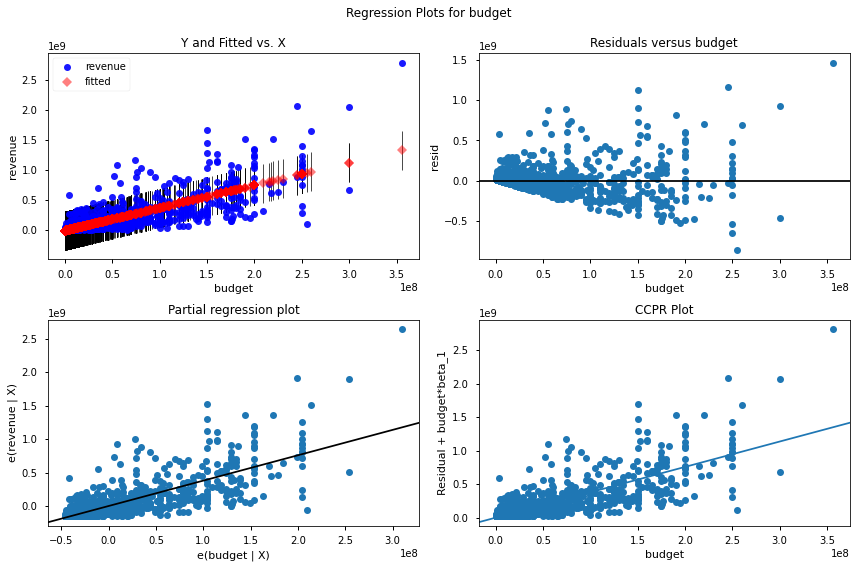

In [10]:
fig = sm.graphics.qqplot(model1.resid,dist=stats.norm,fit=True,line='45')
fig = sm.graphics.plot_regress_exog(model1, "budget", fig=plt.figure(figsize=(12,8)))

## Removing Outliers

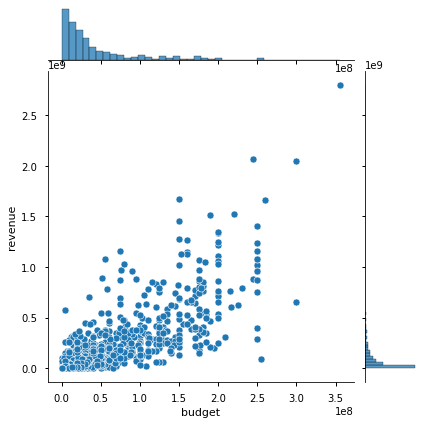

In [11]:
sns.jointplot(data=df,x='budget',y='revenue')

In [12]:
## Get X outliers
X_outliers_Z = sg.find_outliers_z(df['budget'])
y_outliers_Z = sg.find_outliers_z(df['revenue'])

## Combine outliers
idx_outliers_Z = X_outliers_Z  | y_outliers_Z
idx_outliers_Z.sum()

48

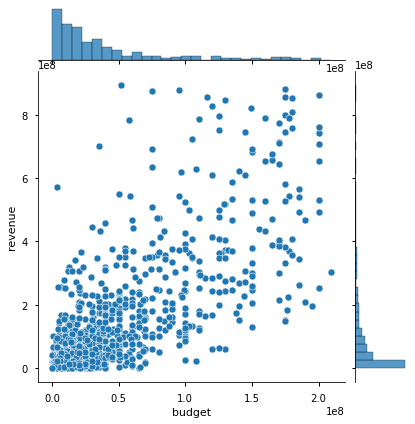

In [13]:
sns.jointplot(data=df[~idx_outliers_Z],x='budget',y='revenue')

In [14]:
## Get X outliers
X_outliers_IQR = sg.find_outliers_IQR(df['budget'])
y_outliers_IQR = sg.find_outliers_IQR(df['revenue'])

## Combine outliers
idx_outliers_IQR = X_outliers_IQR  | y_outliers_IQR
idx_outliers_IQR.sum()

174

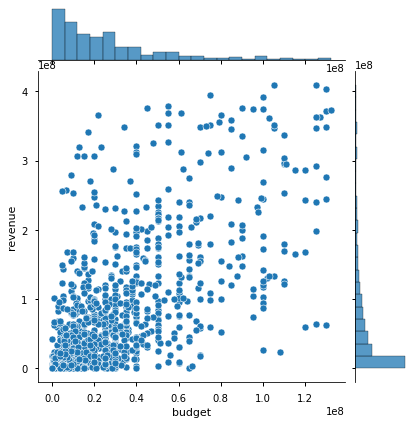

In [15]:
sns.jointplot(data=df[~idx_outliers_IQR],x='budget',y='revenue')

In [16]:
## Create df_clean
df_clean = df[~idx_outliers_IQR].copy()
df_clean

,imdb_id,original_title,title,genres,mpaa_rating,production_companies,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language,genre_list
id,,,,,,,,,,,,,,,,
57214,tt1636826,Project X,Project X,"[{'id': 35, 'name': 'Comedy'}]",R,"[{'id': 1885, 'logo_path': '/xlvoOZr4s1Pygosrw...",2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en,[Comedy]
70981,tt1446714,Prometheus,Prometheus,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",R,"[{'id': 444, 'logo_path': '/42UPdZl6B2cFXgNUAS...",2012-05-30,124.0,130000000,403170142,9183,6.5,46.651,False,en,"[Science Fiction, Adventure, Mystery]"
76492,tt0837562,Hotel Transylvania,Hotel Transylvania,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",PG,"[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...",2012-09-20,91.0,85000000,358375603,6541,6.9,43.148999999999994,False,en,"[Animation, Comedy, Family, Fantasy]"
72331,tt1611224,Abraham Lincoln: Vampire Hunter,Abraham Lincoln: Vampire Hunter,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",R,"[{'id': 1038, 'logo_path': '/o62j8ZNXmRTrq6Thv...",2012-06-20,94.0,69000000,116471580,2462,5.6,41.438,False,en,"[Action, Fantasy, Horror]"
71552,tt1605630,American Reunion,American Reunion,"[{'id': 35, 'name': 'Comedy'}]",R,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...",2012-04-04,113.0,50000000,234989584,3457,6.2,41.098,False,en,[Comedy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",PG-13,"[{'id': 264, 'logo_path': '/fA90qwUKgPhMONqtwY...",2019-12-11,174.0,9000000,4612788,370,7.2,15.434000000000001,False,en,"[Drama, War, History]"
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",PG,"[{'id': 7493, 'logo_path': '/452FO4LcI6lA6bfgl...",2019-11-07,119.0,15600000,11620337,211,6.7,15.075999999999999,False,en,"[Drama, Comedy]"
616584,tt10521814,K-12,K-12,"[{'id': 10402, 'name': 'Music'}, {'id': 27, 'n...",R,"[{'id': 65827, 'logo_path': None, 'name': 'Atl...",2019-09-05,92.0,50000,359377,171,7.6,14.822000000000001,False,en,"[Music, Horror, Fantasy]"


### Model 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     881.0
Date:                Wed, 07 Apr 2021   Prob (F-statistic):          1.98e-143
Time:                        19:16:00   Log-Likelihood:                -21900.
No. Observations:                1126   AIC:                         4.380e+04
Df Residuals:                    1124   BIC:                         4.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.332e+07   2.86e+06      4.649      0.000     7.7e+06    1.89e+07
budget         2.1166      0.071     29.682      0.000       1.977       2.257
==============================================================================
Omnibus:                      290.848   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.435
Skew:                           1.306   Prob(JB):                    5.74e-180
Kurtosis:                       6.282   Cond. No.                     5.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

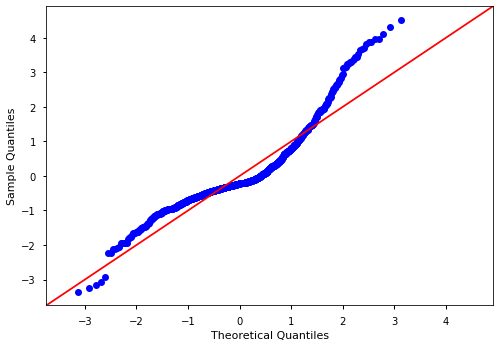

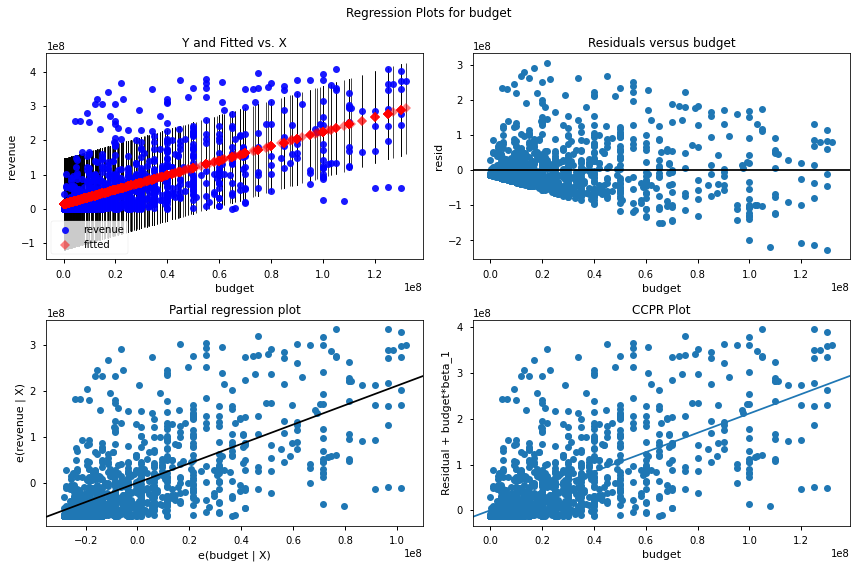

In [17]:
## Get the model params 

f = "revenue~budget"
model = smf.ols(f,df_clean).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,dist=stats.norm,line='45',fit=True);
sm.graphics.plot_regress_exog(model,'budget',plt.figure(figsize=(12,8)));

# Multiple Linear Regression

## Single Regression
 $$y=mx+b$$

 $$y = \beta_1 x_1 + \beta_0 $$

<br><br>
## Multiple Predictor/X Variables

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 +\ldots + \beta_n x_n $$

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-multiple-linear-regression-online-ds-ft-100719/master/images/multiple_reg.png" width=400>

#### $\hat Y$ vs $Y$


- Y: Actual value corresponding to a specific X value

- "Y hat" ($\hat Y$): Predicted value predicted fromn a specific X value.


$$ \hat y = \hat\beta_0 + \hat\beta_1 x_1 + \hat\beta_2 x_2 +\ldots + \hat\beta_n x_n $$ 

where $n$ is the number of predictors, $\beta_0$ is the intercept, and $\hat y$ is the so-called "fitted line" or the predicted value associated with the dependent variable.

In [18]:
df = genre_df.drop(columns=['imdb_id','original_title','genres',
                            'production_companies','original_language',
                            'title','release_date']).copy()
df.reset_index(drop=True,inplace=True)
df

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list
0,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science Fiction
1,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action
2,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure
3,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure
4,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy
...,...,...,...,...,...,...,...,...,...
3383,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Horror
3384,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Thriller
3385,NR,95.0,46,5,0,0.0,0.622,False,Comedy
3386,NR,95.0,46,5,0,0.0,0.622,False,Horror


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpaa_rating   3388 non-null   object 
 1   runtime       3388 non-null   float64
 2   budget        3388 non-null   int64  
 3   revenue       3388 non-null   int64  
 4   vote_count    3388 non-null   int64  
 5   vote_average  3388 non-null   float64
 6   popularity    3388 non-null   float64
 7   adult         3388 non-null   bool   
 8   genre_list    3387 non-null   object 
dtypes: bool(1), float64(3), int64(3), object(2)
memory usage: 215.2+ KB


In [20]:
df.isna().sum()

mpaa_rating     0
runtime         0
budget          0
revenue         0
vote_count      0
vote_average    0
popularity      0
adult           0
genre_list      1
dtype: int64

In [21]:
df.dropna(inplace=True)

In [22]:
df.describe()

,runtime,budget,revenue,vote_count,vote_average,popularity
count,"3,387.0","3,387.0","3,387.0","3,387.0","3,387.0","3,387.0"
mean,109.66164747564216,"54,428,424.91260703","186,371,334.65721878","3,430.440803070564",6.448154709182168,37.220654561558895
std,17.245202282782742,"60,115,870.420383126","296,305,539.4757206","3,996.1064202320185",0.8984327048490975,39.73139928934072
min,78.0,10.0,1.0,0.0,0.0,0.6
25%,96.0,"11,500,000.0","14,666,762.0",732.0,6.0,15.401
50%,107.0,"30,000,000.0","66,308,758.0","1,919.0",6.5,24.328000000000003
75%,120.0,"75,000,000.0","217,048,411.5","4,654.0",7.0,43.119
max,188.0,"356,000,000.0","2,797,800,564.0","25,296.0",8.4,397.25699999999995


In [23]:
# pd.plotting.scatter_matrix(df);

# DEALING WITH CATEGORICAL VARIABLES

- What are categorical variables?
- Understand creating dummy variables for predictors.
- Use pandas and Scikit-Learn to create dumies
- Understand and avoid the "dummy variable trap"

## What are categorical variables?
- Variables that do not represent a continuous/ordinal number. 

## Identifying categorical variables:
What to look for?
1. Column dtype is 'object'
2. Use `df.describe()` -  check for min/max. Are they integers?
3. Use scatterplots & histograms -  look for columns of datapoints

In [24]:
df.columns

Index(['mpaa_rating', 'runtime', 'budget', 'revenue', 'vote_count',
       'vote_average', 'popularity', 'adult', 'genre_list'],
      dtype='object')

In [25]:
cat_cols = df.select_dtypes('O').columns
cat_cols

Index(['mpaa_rating', 'genre_list'], dtype='object')

In [26]:
df[cat_cols]

,mpaa_rating,genre_list
0,PG-13,Science Fiction
1,PG-13,Action
2,PG-13,Adventure
3,PG-13,Adventure
4,PG-13,Fantasy
...,...,...
3383,R,Horror
3384,R,Thriller
3385,NR,Comedy
3386,NR,Horror


In [27]:
num_cols =list(df.select_dtypes('number').columns)
num_cols

['runtime', 'budget', 'revenue', 'vote_count', 'vote_average', 'popularity']

In [28]:
df[num_cols]

,runtime,budget,revenue,vote_count,vote_average,popularity
0,143.0,220000000,1518815515,24252,7.7,151.095
1,143.0,220000000,1518815515,24252,7.7,151.095
2,143.0,220000000,1518815515,24252,7.7,151.095
3,115.0,120000000,829000000,6978,6.5,73.226
4,115.0,120000000,829000000,6978,6.5,73.226
...,...,...,...,...,...,...
3383,120.0,13000000,13000000,0,0.0,2.0709999999999997
3384,120.0,13000000,13000000,0,0.0,2.0709999999999997
3385,95.0,46,5,0,0.0,0.622
3386,95.0,46,5,0,0.0,0.622


In [29]:
df.isna().sum()

mpaa_rating     0
runtime         0
budget          0
revenue         0
vote_count      0
vote_average    0
popularity      0
adult           0
genre_list      0
dtype: int64

In [30]:
## Inspect the Value Counts for Each Str Col
for col in cat_cols:
    display(df[col].value_counts(dropna=False).sort_index())
    print()

G          34
NC-17       2
NR         43
PG        571
PG-13    1299
R        1438
Name: mpaa_rating, dtype: int64

Action             362
Adventure          266
Animation          100
Comedy             419
Crime              190
Documentary          8
Drama              610
Family             141
Fantasy            140
History             80
Horror             168
Music               46
Mystery            101
Romance            163
Science Fiction    178
Thriller           364
War                 37
Western             14
Name: genre_list, dtype: int64

## Transforming Categorical Variables

To use categorical variables for regression, they must be transformed.
There are 2 methods to dealing with them:
1. Label Encoding
    - Replace string categories with integer values (0 to n)
    - Can be done with:
        1. Pandas 
        2. Scikit Learn

2. One-hot / dummy encoding
    - Turn each category in a categorical variable into its own variable, that is either a 0 or 1. 0 for rows that do not belong to that sub-category. 1 for rows that belong to the sub-category
    - Can be done with:
        1. Pandas
        2. Scikit Learn


### Label Encoding

In [31]:
## Check the Value Counts for our test column - "BldgType"
df['mpaa_rating'].value_counts(normalize=True)

R         0.4245645113669914
PG-13    0.38352524357838796
PG       0.16858576911721287
NR      0.012695600826690287
G       0.010038382049010924
NC-17   0.000590493061706525
Name: mpaa_rating, dtype: float64

#### Via pandas.cat.codes

In [32]:
## Label Encode with .cat.codesd
df['mpaa_rating'] = df['mpaa_rating'].astype('category')
df['mpaa_rating_le'] = df['mpaa_rating'].cat.codes
df['mpaa_rating_le'].value_counts(normalize=True)

5     0.4245645113669914
4    0.38352524357838796
3    0.16858576911721287
2   0.012695600826690287
0   0.010038382049010924
1   0.000590493061706525
Name: mpaa_rating_le, dtype: float64

#### Via Sklearn's LabelEncoder

In [33]:
## Using sklearn LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['mpaa_rating_enc'] = encoder.fit_transform(df['mpaa_rating'])
df.head()

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list,mpaa_rating_le,mpaa_rating_enc
0,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science Fiction,4,4
1,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action,4,4
2,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure,4,4
3,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure,4,4
4,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy,4,4


In [34]:
encoder.inverse_transform(df['mpaa_rating_enc'])

array(['PG-13', 'PG-13', 'PG-13', ..., 'NR', 'NR', 'NR'], dtype=object)

In [35]:
# df

### Dummy Encoding / One-Hot Encoding

#### Via Pandas.get_dummies()

In [36]:
df['genre_list'].unique()

array(['Science Fiction', 'Action', 'Adventure', 'Fantasy', 'Drama',
       'Romance', 'Family', 'Animation', 'Comedy', 'Crime', 'Thriller',
       'Mystery', 'Horror', 'Western', 'History', 'War', 'Music',
       'Documentary'], dtype=object)

In [37]:
df_dummies = pd.get_dummies(df,columns=cat_cols,prefix="ohe")
df_dummies

,runtime,budget,revenue,vote_count,vote_average,popularity,adult,mpaa_rating_le,mpaa_rating_enc,ohe_G,ohe_NC-17,ohe_NR,ohe_PG,ohe_PG-13,ohe_R,ohe_Action,ohe_Adventure,ohe_Animation,ohe_Comedy,ohe_Crime,ohe_Documentary,ohe_Drama,ohe_Family,ohe_Fantasy,ohe_History,ohe_Horror,ohe_Music,ohe_Mystery,ohe_Romance,ohe_Science Fiction,ohe_Thriller,ohe_War,ohe_Western
0,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,115.0,120000000,829000000,6978,6.5,73.226,False,4,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,115.0,120000000,829000000,6978,6.5,73.226,False,4,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,5,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3384,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,5,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3385,95.0,46,5,0,0.0,0.622,False,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3386,95.0,46,5,0,0.0,0.622,False,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Via Scikit-Learn's OneHotEncoder

In [38]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
ohe_vars = encoder.fit_transform(df[cat_cols])
ohe_vars
# pd.DataFrame(ohe_vars,columns=binarizer.classes_)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [39]:
cat_vars = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(cat_cols))
cat_vars

,mpaa_rating_G,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R,genre_list_Action,genre_list_Adventure,genre_list_Animation,genre_list_Comedy,genre_list_Crime,genre_list_Documentary,genre_list_Drama,genre_list_Family,genre_list_Fantasy,genre_list_History,genre_list_Horror,genre_list_Music,genre_list_Mystery,genre_list_Romance,genre_list_Science Fiction,genre_list_Thriller,genre_list_War,genre_list_Western
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3383,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3384,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3385,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### The Dummy Variable Trap


In [40]:
df_dummies = pd.get_dummies(df['mpaa_rating'],drop_first=True)#,prefix="ohe")
df_dummies

,NC-17,NR,PG,PG-13,R
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
3383,0,0,0,0,1
3384,0,0,0,0,1
3385,0,1,0,0,0
3386,0,1,0,0,0


## Testing Out Our Model With Encoded Categorical Data

In [41]:
cat_cols

Index(['mpaa_rating', 'genre_list'], dtype='object')

In [42]:
# df_clean

In [43]:
df.columns=[col.lower().replace(' ','_') for col in df.columns]
df

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list,mpaa_rating_le,mpaa_rating_enc
0,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science Fiction,4,4
1,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action,4,4
2,PG-13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure,4,4
3,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure,4,4
4,PG-13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy,4,4
...,...,...,...,...,...,...,...,...,...,...,...
3383,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Horror,5,5
3384,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Thriller,5,5
3385,NR,95.0,46,5,0,0.0,0.622,False,Comedy,2,2
3386,NR,95.0,46,5,0,0.0,0.622,False,Horror,2,2


In [44]:
genres = df['genre_list'].unique()
genre_dict = {}
for genre in genres:
    genre_dict[genre] = genre.replace(' ','_')
genre_dict

{'Science Fiction': 'Science_Fiction',
 'Action': 'Action',
 'Adventure': 'Adventure',
 'Fantasy': 'Fantasy',
 'Drama': 'Drama',
 'Romance': 'Romance',
 'Family': 'Family',
 'Animation': 'Animation',
 'Comedy': 'Comedy',
 'Crime': 'Crime',
 'Thriller': 'Thriller',
 'Mystery': 'Mystery',
 'Horror': 'Horror',
 'Western': 'Western',
 'History': 'History',
 'War': 'War',
 'Music': 'Music',
 'Documentary': 'Documentary'}

In [45]:
df['genre_list'] = df['genre_list'].replace(genre_dict)

In [46]:
ratings = df['mpaa_rating'].unique()
rating_dict = {}
for rating in ratings:
    rating_dict[rating] = rating.replace(' ','_').replace('-','_')
rating_dict

{'PG-13': 'PG_13',
 'PG': 'PG',
 'R': 'R',
 'NR': 'NR',
 'G': 'G',
 'NC-17': 'NC_17'}

In [47]:
df['mpaa_rating'] = df['mpaa_rating'].replace(rating_dict)
df

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list,mpaa_rating_le,mpaa_rating_enc
0,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science_Fiction,4,4
1,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action,4,4
2,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure,4,4
3,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure,4,4
4,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy,4,4
...,...,...,...,...,...,...,...,...,...,...,...
3383,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Horror,5,5
3384,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Thriller,5,5
3385,NR,95.0,46,5,0,0.0,0.622,False,Comedy,2,2
3386,NR,95.0,46,5,0,0.0,0.622,False,Horror,2,2


In [48]:
df_dummies = pd.get_dummies(df,columns=cat_cols,drop_first=True)#,prefix="ohe")
df_dummies

,runtime,budget,revenue,vote_count,vote_average,popularity,adult,mpaa_rating_le,mpaa_rating_enc,mpaa_rating_NC_17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG_13,mpaa_rating_R,genre_list_Adventure,genre_list_Animation,genre_list_Comedy,genre_list_Crime,genre_list_Documentary,genre_list_Drama,genre_list_Family,genre_list_Fantasy,genre_list_History,genre_list_Horror,genre_list_Music,genre_list_Mystery,genre_list_Romance,genre_list_Science_Fiction,genre_list_Thriller,genre_list_War,genre_list_Western
0,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,143.0,220000000,1518815515,24252,7.7,151.095,False,4,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,115.0,120000000,829000000,6978,6.5,73.226,False,4,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,115.0,120000000,829000000,6978,6.5,73.226,False,4,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3384,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3385,95.0,46,5,0,0.0,0.622,False,2,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3386,95.0,46,5,0,0.0,0.622,False,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [49]:
df_dummies.dtypes

runtime                       float64
budget                          int64
revenue                         int64
vote_count                      int64
vote_average                  float64
popularity                    float64
adult                            bool
mpaa_rating_le                   int8
mpaa_rating_enc                 int64
mpaa_rating_NC_17               uint8
mpaa_rating_NR                  uint8
mpaa_rating_PG                  uint8
mpaa_rating_PG_13               uint8
mpaa_rating_R                   uint8
genre_list_Adventure            uint8
genre_list_Animation            uint8
genre_list_Comedy               uint8
genre_list_Crime                uint8
genre_list_Documentary          uint8
genre_list_Drama                uint8
genre_list_Family               uint8
genre_list_Fantasy              uint8
genre_list_History              uint8
genre_list_Horror               uint8
genre_list_Music                uint8
genre_list_Mystery              uint8
genre_list_R

In [50]:
features = ' + '.join(df_dummies.drop("revenue",axis=1).columns)
features

'runtime + budget + vote_count + vote_average + popularity + adult + mpaa_rating_le + mpaa_rating_enc + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R + genre_list_Adventure + genre_list_Animation + genre_list_Comedy + genre_list_Crime + genre_list_Documentary + genre_list_Drama + genre_list_Family + genre_list_Fantasy + genre_list_History + genre_list_Horror + genre_list_Music + genre_list_Mystery + genre_list_Romance + genre_list_Science_Fiction + genre_list_Thriller + genre_list_War + genre_list_Western'

In [51]:
f = "revenue~" + features
f

'revenue~runtime + budget + vote_count + vote_average + popularity + adult + mpaa_rating_le + mpaa_rating_enc + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R + genre_list_Adventure + genre_list_Animation + genre_list_Comedy + genre_list_Crime + genre_list_Documentary + genre_list_Drama + genre_list_Family + genre_list_Fantasy + genre_list_History + genre_list_Horror + genre_list_Music + genre_list_Mystery + genre_list_Romance + genre_list_Science_Fiction + genre_list_Thriller + genre_list_War + genre_list_Western'

In [52]:
model = smf.ols(f,df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     411.6
Date:                Wed, 07 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:16:03   Log-Likelihood:                -68402.
No. Observations:                3387   AIC:                         1.369e+05
Df Residuals:                    3359   BIC:                         1.370e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.151e+08   3.61e+07      3.188      0.001    4.43e+07    1.86e+08
adult[T.True]                 -2.6516      5.453     -0.486      0.627     -13.344       8.041
runtime                    -6.034e+05   1.92e+05     -3.144      0.002    -9.8e+05   -2.27e+05
budget                         1.9930      0.072     27.824      0.000       1.853       2.133
vote_count                  3.554e+04    960.831     36.988      0.000    3.37e+04    3.74e+04
vote_average                -6.29e+06   3.45e+06     -1.824      0.068   -1.31e+07    4.71e+05
popularity                  1.106e+06   7.72e+04     14.335      0.000    9.55e+05    1.26e+06
mpaa_rating_le             -1.459e+07   3.62e+06     -4.036      0.000   -2.17e+07    -7.5e+06
mpaa_rating_enc            -1.459e+07   3.62e+06     -4.036      0.000   -2.17e+07    -7.5e+06
mpaa_rating_NC_17          -7.884e+07   1.02e+08     -0.775      0.439   -2.78e+08    1.21e+08
mpaa_rating_NR             -3.688e+07   2.41e+07     -1.529      0.126   -8.42e+07    1.04e+07
mpaa_rating_PG              4.029e+07   9.97e+06      4.043      0.000    2.08e+07    5.98e+07
mpaa_rating_PG_13          -6.882e+06   9.04e+06     -0.762      0.446   -2.46e+07    1.08e+07
mpaa_rating_R               8.932e+06   1.36e+07      0.656      0.512   -1.77e+07    3.56e+07
genre_list_Adventure         6.26e+06    1.2e+07      0.522      0.602   -1.72e+07    2.98e+07
genre_list_Animation        4.372e+07   1.79e+07      2.441      0.015     8.6e+06    7.88e+07
genre_list_Comedy           3.602e+07   1.07e+07      3.372      0.001    1.51e+07     5.7e+07
genre_list_Crime            1.981e+07   1.32e+07      1.503      0.133   -6.03e+06    4.57e+07
genre_list_Documentary       6.43e+07   5.16e+07      1.247      0.212   -3.68e+07    1.65e+08
genre_list_Drama            2.674e+07   1.01e+07      2.646      0.008    6.93e+06    4.65e+07
genre_list_Family           2.338e+07   1.61e+07      1.449      0.148   -8.27e+06     5.5e+07
genre_list_Fantasy          -7.29e+06   1.46e+07     -0.500      0.617   -3.59e+07    2.13e+07
genre_list_History          2.934e+07   1.83e+07      1.599      0.110   -6.63e+06    6.53e+07
genre_list_Horror            4.31e+07   1.39e+07      3.111      0.002    1.59e+07    7.03e+07
genre_list_Music            7.469e+07   2.28e+07      3.278      0.001       3e+07    1.19e+08
genre_list_Mystery          1.386e+07   1.64e+07      0.845      0.398   -1.83e+07     4.6e+07
genre_list_Romance            4.7e+07    1.4e+07      3.362      0.001    1.96e+07    7.44e+07
genre_list_Science_Fiction -2.683e+07   1.32e+07     -2.036      0.042   -5.27e+07   -9.91e+05
genre_list_Thriller         2.983e+07    1.1e+07      2.723      0.006    8.35e+06    5.13e+07
genre_list_War              1.447e+07    2.

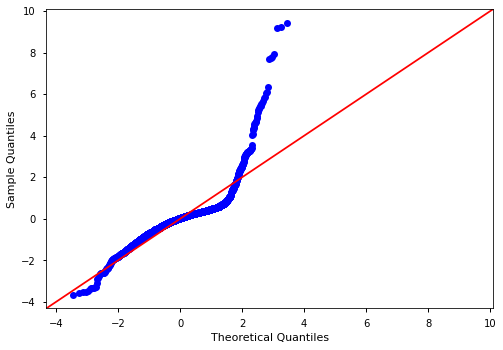

In [53]:
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')

# fig = sm.graphics.plot_regress_exog(model, "", fig=plt.figure(figsize=(12,8)))

In [54]:
df

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list,mpaa_rating_le,mpaa_rating_enc
0,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science_Fiction,4,4
1,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action,4,4
2,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure,4,4
3,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure,4,4
4,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy,4,4
...,...,...,...,...,...,...,...,...,...,...,...
3383,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Horror,5,5
3384,R,120.0,13000000,13000000,0,0.0,2.0709999999999997,False,Thriller,5,5
3385,NR,95.0,46,5,0,0.0,0.622,False,Comedy,2,2
3386,NR,95.0,46,5,0,0.0,0.622,False,Horror,2,2


In [55]:
df.drop(columns=[col for col in df.columns if '_le' in col],inplace=True,axis=1)

In [56]:
df.head()

,mpaa_rating,runtime,budget,revenue,vote_count,vote_average,popularity,adult,genre_list,mpaa_rating_enc
0,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Science_Fiction,4
1,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Action,4
2,PG_13,143.0,220000000,1518815515,24252,7.7,151.095,False,Adventure,4
3,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Adventure,4
4,PG_13,115.0,120000000,829000000,6978,6.5,73.226,False,Fantasy,4


In [57]:
cat_cols

Index(['mpaa_rating', 'genre_list'], dtype='object')

In [58]:
"Licks ~ C(Group) + C(Phase)"

'Licks ~ C(Group) + C(Phase)'

In [61]:
cat_features = '+'.join([f"C({col})" for col in cat_cols])
cat_features

'C(mpaa_rating)+C(genre_list)'

In [62]:
num_cols = list(df.select_dtypes('number').columns)
num_cols.remove('revenue')
num_cols

['runtime',
 'budget',
 'vote_count',
 'vote_average',
 'popularity',
 'mpaa_rating_enc']

In [63]:
## EITHER USE FORMULA OLS or normal OLS 
features = '+'.join(num_cols) + '+' + cat_features
features =  features.replace('revenue','')
features

'runtime+budget+vote_count+vote_average+popularity+mpaa_rating_enc+C(mpaa_rating)+C(genre_list)'

In [64]:
f = "revenue ~" + features
f

'revenue ~runtime+budget+vote_count+vote_average+popularity+mpaa_rating_enc+C(mpaa_rating)+C(genre_list)'

In [65]:
## Non-Formula OLS
model =  smf.ols(f,df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     411.6
Date:                Wed, 07 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:18:58   Log-Likelihood:                -68402.
No. Observations:                3387   AIC:                         1.369e+05
Df Residuals:                    3359   BIC:                         1.370e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         1.151e+08   3.61e+07      3.188      0.001    4.43e+07    1.86e+08
C(mpaa_rating)[T.NC_17]           -7.91e+07   1.02e+08     -0.777      0.437   -2.79e+08    1.21e+08
C(mpaa_rating)[T.NR]              -3.74e+07   2.42e+07     -1.547      0.122   -8.48e+07       1e+07
C(mpaa_rating)[T.PG]              3.951e+07      1e+07      3.950      0.000    1.99e+07    5.91e+07
C(mpaa_rating)[T.PG_13]          -7.924e+06   8.92e+06     -0.888      0.375   -2.54e+07    9.57e+06
C(mpaa_rating)[T.R]               7.629e+06   1.33e+07      0.572      0.568   -1.85e+07    3.38e+07
C(genre_list)[T.Adventure]         6.26e+06    1.2e+07      0.522      0.602   -1.72e+07    2.98e+07
C(genre_list)[T.Animation]        4.372e+07   1.79e+07      2.441      0.015     8.6e+06    7.88e+07
C(genre_list)[T.Comedy]           3.602e+07   1.07e+07      3.372      0.001    1.51e+07     5.7e+07
C(genre_list)[T.Crime]            1.981e+07   1.32e+07      1.503      0.133   -6.03e+06    4.57e+07
C(genre_list)[T.Documentary]       6.43e+07   5.16e+07      1.247      0.212   -3.68e+07    1.65e+08
C(genre_list)[T.Drama]            2.674e+07   1.01e+07      2.646      0.008    6.93e+06    4.65e+07
C(genre_list)[T.Family]           2.338e+07   1.61e+07      1.449      0.148   -8.27e+06     5.5e+07
C(genre_list)[T.Fantasy]          -7.29e+06   1.46e+07     -0.500      0.617   -3.59e+07    2.13e+07
C(genre_list)[T.History]          2.934e+07   1.83e+07      1.599      0.110   -6.63e+06    6.53e+07
C(genre_list)[T.Horror]            4.31e+07   1.39e+07      3.111      0.002    1.59e+07    7.03e+07
C(genre_list)[T.Music]            7.469e+07   2.28e+07      3.278      0.001       3e+07    1.19e+08
C(genre_list)[T.Mystery]          1.386e+07   1.64e+07      0.845      0.398   -1.83e+07     4.6e+07
C(genre_list)[T.Romance]            4.7e+07    1.4e+07      3.362      0.001    1.96e+07    7.44e+07
C(genre_list)[T.Science_Fiction] -2.683e+07   1.32e+07     -2.036      0.042   -5.27e+07   -9.91e+05
C(genre_list)[T.Thriller]         2.983e+07    1.1e+07      2.723      0.006    8.35e+06    5.13e+07
C(genre_list)[T.War]              1.447e+07    2.5e+07      0.578      0.563   -3.46e+07    6.35e+07
C(genre_list)[T.Western]         -5.961e+07   3.93e+07     -1.518      0.129   -1.37e+08    1.74e+07
runtime                          -6.034e+05   1.92e+05     -3.144      0.002    -9.8e+05   -2.27e+05
budget                               1.9930      0.072     27.824      0.000       1.853       2.133
vote_count                        3.554e+04    960.831     36.988      0.000    3.37e+04    3.74e+04
vote_average                      -6.29e+06   3.45e+06     -1.824      0.068   -1.31e+07    4.71e+05
popularity                        1.106e+06   7.72e+0

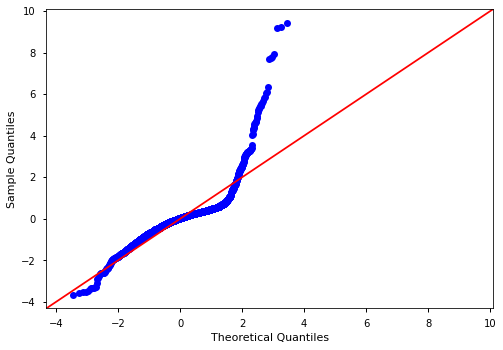

In [67]:
## View Model Summary
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')


# Multicollinearity
- An additional concern to check for.
- Rule of thumb is if correlation between vars is >0.70 is too high


In [70]:
## Get the correlation matrix for our model_df
corr = df.corr()
corr

,runtime,budget,revenue,vote_count,vote_average,popularity,adult,mpaa_rating_enc
runtime,1.0,0.3981147243378196,0.33632210367701304,0.45229768650068697,0.36526940865288077,0.2855183815330808,nan,0.1715019448245211
budget,0.3981147243378196,1.0,0.7815531537554979,0.6469959772707179,0.20616969561368736,0.5261751167947655,nan,-0.3246875450360802
revenue,0.33632210367701304,0.7815531537554979,1.0,0.775554260856115,0.31931134238548187,0.579956626520919,nan,-0.27324161262609326
vote_count,0.45229768650068697,0.6469959772707179,0.775554260856115,1.0,0.45446594129392953,0.5149005471361249,nan,-0.06004855009645359
vote_average,0.36526940865288077,0.20616969561368736,0.31931134238548187,0.45446594129392953,1.0,0.26843996218155397,nan,-0.06180723672635685
popularity,0.2855183815330808,0.5261751167947655,0.579956626520919,0.5149005471361249,0.26843996218155397,1.0,nan,-0.06653430580337333
adult,nan,nan,nan,nan,nan,nan,nan,nan
mpaa_rating_enc,0.1715019448245211,-0.3246875450360802,-0.27324161262609326,-0.06004855009645359,-0.06180723672635685,-0.06653430580337333,nan,1.0


In [71]:
mask = np.zeros_like(corr)
mask

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [72]:
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

<AxesSubplot:>

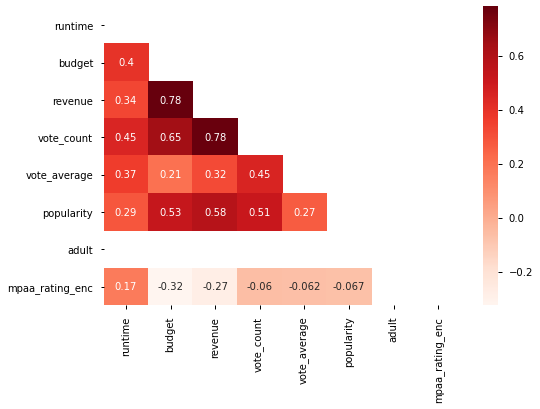

In [74]:
sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)

In [ ]:
# Checking Visually 

def multiplot():

    return fig, ax


# 